# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option B: Synthetic Generator (Use if you don't have data ready)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [3]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_vol_30'] = df['ret'].rolling(30).std().shift(1)
df['roll_max_20'] = df['ret'].rolling(20).max().shift(1)

df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_vol_30,roll_max_20,y_next_ret,y_up
2021-02-12,98.015662,-0.007100,-0.007126,-0.003857,-0.006637,0.009531,0.020804,0.011086,1
2021-02-15,99.102234,0.011086,0.011025,-0.007100,-0.005236,0.009594,0.020804,-0.016080,0
2021-02-16,97.508663,-0.016080,-0.016211,0.011086,-0.002270,0.009830,0.020804,0.005670,1
2021-02-17,98.061567,0.005670,0.005654,-0.016080,-0.001020,0.010219,0.020804,-0.020139,0
2021-02-18,96.086745,-0.020139,-0.020344,0.005670,-0.002056,0.010246,0.020804,-0.006302,0


## Split

In [4]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'roll_vol_30', 'roll_max_20']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

RMSE: 0.0002123638132013428


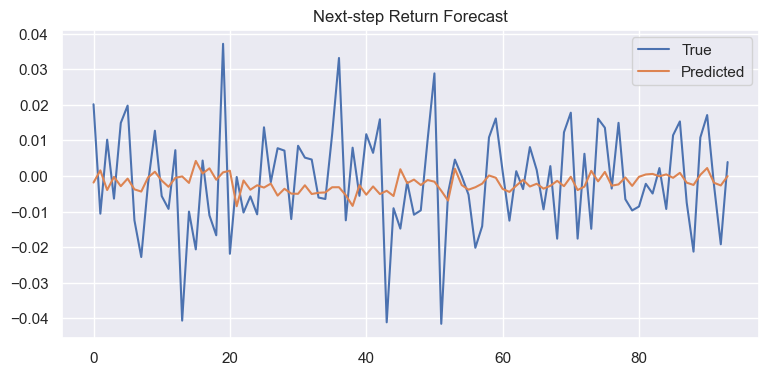

In [5]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred)
print('RMSE:', rmse)

plt.plot(y_te_reg.values, label='True')
plt.plot(pred, label='Predicted')
plt.legend(); plt.title('Next-step Return Forecast'); plt.show()

              precision    recall  f1-score   support

           0       0.58      0.79      0.67        52
           1       0.52      0.29      0.37        42

    accuracy                           0.56        94
   macro avg       0.55      0.54      0.52        94
weighted avg       0.55      0.56      0.53        94



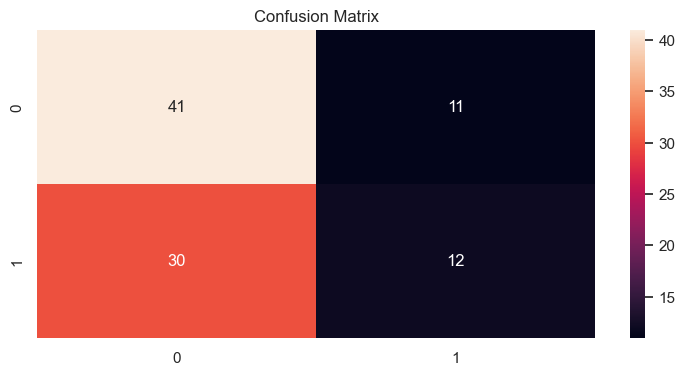

In [6]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)

The model captured some signal from the lag and rolling features, but performance was modest — accuracy and F1 were only slightly above chance, which is common with noisy financial return data. The pipeline and time-aware split worked correctly, and diagnostics suggest the model is not overfitting badly, but assumptions like stationarity and stable relationships are weak in practice. 

What worked: the lag/rolling features added some predictive structure and the pipeline ran cleanly.  
What failed: predictions are unstable and metrics show limited reliability, especially during volatile periods.  
Overall, this baseline is useful for learning but I would not trust it for trading decisions. A logical next step might be to add richer features, test more robust models, and evaluate stability across different time windows.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.